In [1]:
import pymc3 as pm
import numpy as np
# import numpy.linalg
from matplotlib import pyplot as plt

In [2]:
V = [
    'dog',
    'aunt',
    'cat',
    'square',
    'house',
    'root',
    'mouse',
    'cow',
    'palm',
    'tree',
    'mom',
    'sun',
    'moon',
    'father',
    'spoon',
    'circle',
    'mug',
    'glass'
]
V_arr = np.array(V)

In [3]:
def build_topic_distribution(seed=1234):
    np.random.seed(seed)
    vocabulary_size = len(V)
    distribution = np.random.random(vocabulary_size)
    return distribution / distribution.sum()

In [4]:
build_topic_distribution()

array([0.01973417, 0.0641021 , 0.04510347, 0.08092336, 0.08036872,
       0.02808795, 0.02848688, 0.08262492, 0.0987267 , 0.09025611,
       0.0368695 , 0.05162255, 0.07042403, 0.07343683, 0.03815064,
       0.05782566, 0.0518377 , 0.0014187 ])

In [5]:
topics = {  # Betas
    'red': build_topic_distribution(seed=1),
    'blue': build_topic_distribution(seed=2),
    'green': build_topic_distribution(seed=3),
    'pink': build_topic_distribution(seed=4),
    'yellow': build_topic_distribution(seed=5)
}

In [6]:
topics['red']

array([5.95139825e-02, 1.02798842e-01, 1.63226420e-05, 4.31464413e-02,
       2.09438049e-02, 1.31778118e-02, 2.65815397e-02, 4.93156112e-02,
       5.66234210e-02, 7.68955339e-02, 5.98240254e-02, 9.77889437e-02,
       2.91777592e-02, 1.25317765e-01, 3.90853414e-03, 9.56836599e-02,
       5.95543411e-02, 7.97316600e-02])

In [7]:
topics['red'].sum()

1.0

In [8]:
topics_number = len(topics)
topics_number

5

In [9]:
np.random.seed(1984)
topic_mean = np.random.random(len(topics)) 
topic_mean /= topic_mean.sum()  # Mu
topic_mean

array([0.00775911, 0.2647408 , 0.04999273, 0.427745  , 0.24976236])

In [10]:
np.random.seed(12)
topic_covariance = np.random.random((topics_number, topics_number))
topic_covariance = np.dot(topic_covariance, topic_covariance.T)
topic_covariance

array([[0.9258647 , 1.32977215, 1.1960876 , 1.02902203, 0.2354462 ],
       [1.32977215, 2.59107874, 1.65456663, 1.74944266, 0.87948846],
       [1.1960876 , 1.65456663, 2.06661948, 1.5962034 , 0.45713552],
       [1.02902203, 1.74944266, 1.5962034 , 1.42787331, 0.61474357],
       [0.2354462 , 0.87948846, 0.45713552, 0.61474357, 0.71282345]])

In [11]:
def transform_proportions(eta):
    # Not sure about this
    theta = np.exp(eta)
    theta /= theta.sum()
    return theta.squeeze()

In [24]:
# Correct with this: https://numpy.org/doc/stable/reference/random/index.html#random-quick-start

# Building a document:
N = 10

seed = 1979
np.random.seed(seed)

# Eta
topic_proportions = np.random.multivariate_normal(topic_mean, topic_covariance, 1)  # (in LDA this is a Dirichlet)

# Theta
topic_normalized_proportions = transform_proportions(topic_proportions)

# BoW
document = np.zeros(len(V))

for n in range(N):
    topic_assignment = np.random.multinomial(1, pvals=topic_normalized_proportions).squeeze().astype(bool)
    assigned_topic = np.array(list(topics.keys()))[topic_assignment][0]
    assigned_topic_distribution = topics[assigned_topic]
    word_mask = np.random.multinomial(1, pvals=assigned_topic_distribution).squeeze()
    word = V_arr[word_mask.astype(bool)][0]
    document += word_mask
    print(f'{n}-th word drawn from topic {assigned_topic} is {word}')
document

0-th word drawn from topic green is square
1-th word drawn from topic green is glass
2-th word drawn from topic blue is house
3-th word drawn from topic green is tree
4-th word drawn from topic green is glass
5-th word drawn from topic green is glass
6-th word drawn from topic blue is sun
7-th word drawn from topic blue is palm
8-th word drawn from topic red is father
9-th word drawn from topic blue is father


array([0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 2., 0., 0., 0.,
       3.])

## Lasso

I am simulating a covariance matrix sigma (suppose we find it with the VEM algorithm), inverting it and using it to build an adjacency matrix.

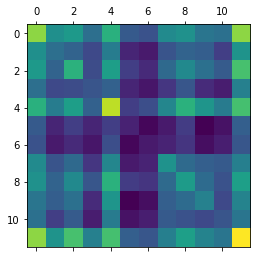

In [155]:
size = 12
seed = 1997
np.random.seed(seed)
sigma = np.random.random((size, size))
sigma = np.dot(sigma, sigma.T)  # This way it becomes positive semidefinite
# print(sigma)
plt.matshow(sigma)

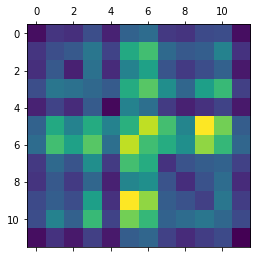

In [156]:
sigma_inv = sigma**-1 
# print(sigma_inv)
plt.matshow(sigma_inv)

I use Lasso to decide which edges to keep or to discard.

In [148]:
from sklearn.linear_model import Lasso

In [157]:
rho = 0.005  # Lasso penalization

adjacency = np.zeros((size, size))

for i in range(size -1):
    
    
    
    lasso = Lasso(alpha=rho)
    lasso.fit(X=sigma_inv[:,[j for j in range(size) if j > i]], y=sigma_inv[:,i])
    
#     print(i)
#     print(lasso.coef_)
    
    new_line = (lasso.coef_ != 0).astype(int)  # setting 1's where the coefficients are different from zero
    adjacency[i, i+1:] = new_line  # Writing the i-th line of the adjacency matrix (above diagonal)
    
adjacency += adjacency.T  # Making it symmetric

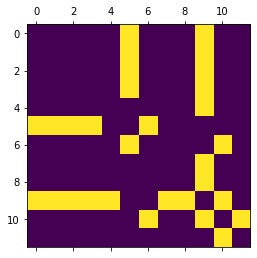

In [158]:
# print(adjacency)
plt.matshow(adjacency)

In [ ]:
# Saving it in a format that can be read by "Gephi" application

In [152]:
import networkx as nx

In [153]:
g = nx.convert_matrix.from_numpy_array(adjacency)

In [154]:
nx.write_gexf(g, 'simulated.gexf')